## Exercise 5
### PageRank Assignment

#### Lakkas Ioannis

* Basic Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import scipy
import networkx as nx
%matplotlib inline

* We load the data

In [2]:
with zipfile.ZipFile("stanweb.dat.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

In [3]:
df = pd.read_csv('data/stanweb.dat','\s',header = None, dtype = 'float')

<ipython-input-3-8e64c7b0141a>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('data/stanweb.dat','\s',header = None, dtype = 'float')


In [4]:
df.head()

,0,1,2
0,1.0,6548.0,0.500000
1,1.0,15409.0,0.500000
2,2.0,252915.0,0.032258
3,2.0,246897.0,0.032258
4,2.0,251658.0,0.032258


In [5]:
df.shape

(2382912, 3)

In [6]:
df.columns = ['Node','Outlink', 'Probability']

In [7]:
df[['Node','Outlink']] = df[['Node','Outlink']].astype(int)

In [8]:
df.head()

,Node,Outlink,Probability
0,1,6548,0.500000
1,1,15409,0.500000
2,2,252915,0.032258
3,2,246897,0.032258
4,2,251658,0.032258


* We print all the nodes (incoming and outgoing) of node 8

In [9]:
df[(df['Node'] == 8) | (df['Outlink'] == 8)]

,Node,Outlink,Probability
53,8,270771,0.142857
54,8,248139,0.142857
55,8,222332,0.142857
56,8,86240,0.142857
57,8,41117,0.142857
58,8,58764,0.142857
59,8,35084,0.142857


* And now we can take some useful statistics in order to become more familiar with the matrix.

In [10]:
df.describe()

,Node,Outlink,Probability
count,2.382912e+06,2.382912e+06,2.382912e+06
mean,1.408497e+05,1.441267e+05,1.182297e-01
std,8.125994e+04,8.079114e+04,1.473778e-01
min,1.000000e+00,2.000000e+00,2.415459e-03
25%,7.054700e+04,7.310000e+04,2.857143e-02
50%,1.408485e+05,1.441525e+05,6.250000e-02
75%,2.110552e+05,2.183032e+05,1.666667e-01
max,2.819030e+05,2.819030e+05,1.000000e+00


In [11]:
graph = nx.DiGraph(name = 'Google matrix graph')
m = df.values
for i in range(0, m.shape[0]):
    # Add graph nodes and edges.
    graph.add_node(m[i, 0].astype(np.int32))
    graph.add_node(m[i, 1].astype(np.int32))
    graph.add_edge(m[i, 0].astype(np.int32), m[i, 1].astype(np.int32), weight = m[i, 2].astype(np.float64))

In [12]:
def plot_graph(graph, highlight_nodes:[] = None, size = (10, 10)):


        _, ax = plt.subplots(figsize = size)
        
        
        position = nx.shell_layout(graph)

        out_edges = [(u, v) for (u, v, d) in graph.out_edges(data = True)]

        out_edge_labels = dict([((u, v, ), '{:.5f}'.format(d['weight'])) for u, v, d in graph.out_edges(data = True)])

        # Highlight some nodes.
        node_color_map = []

        if highlight_nodes is not None:
            for node in graph:
                if node in highlight_nodes:
                    node_color_map.append('green')
                else: 
                    node_color_map.append('grey')
        else:
            node_color_map = ['grey']

        # Draw nodes.
        nx.draw_networkx_nodes(graph, pos = position, node_color = node_color_map, node_size = 500, alpha = 0.5, ax = ax)
        
        # Draw node labels.
        nx.draw_networkx_labels(graph, pos = position, font_weight = 'bold',ax = ax)
        
        # Draw out-edges.
        nx.draw_networkx_edges(graph,pos = position,edgelist = out_edges,width = 2,alpha = 0.5,edge_color = 'black',ax = ax)

        nx.draw_networkx_edge_labels(graph, pos = position, edge_labels = out_edge_labels, label_pos = 0.8, font_size = 9, alpha = 0.8, ax = ax)

        return ax

In [13]:
nodes_1 = np.unique(df[df['Node'].isin([8])]['Node'])
nodes_2 = np.unique(df[df['Node'].isin([8])]['Outlink'])
nodes_1_2 = np.concatenate([nodes_1, nodes_2])

subgraph = graph.subgraph(nodes_1_2)

<AxesSubplot:>

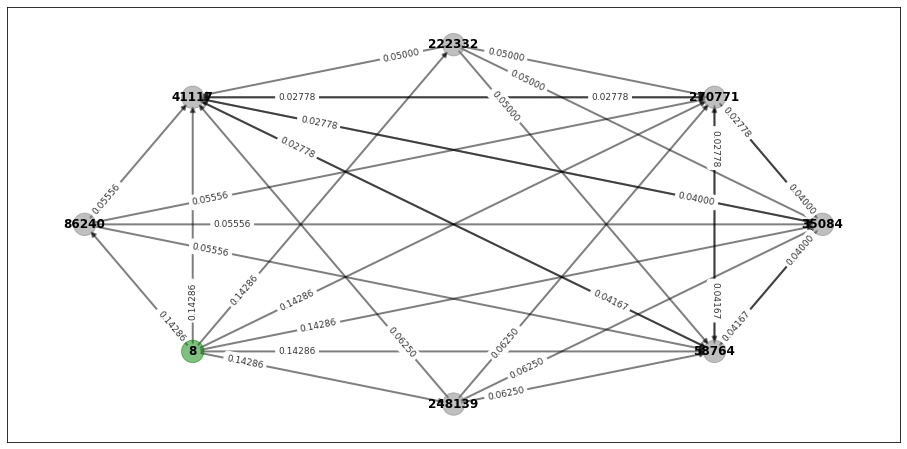

In [14]:
plot_graph(graph = subgraph, highlight_nodes = [8], size = (16, 8))

* Now because the table is really big and so the pandas dataframe may struggle to deal with it, we convert it to a sparse row matrix

In [15]:
sparse_row_matrix = nx.to_scipy_sparse_matrix(graph, np.sort(graph.nodes), format = 'csr', dtype = np.float64)

In [16]:
sparse_row_matrix.shape

(281903, 281903)

#### Part 1a)

<font color='green'> a) Find the vector π with

<font color='green'>      i) the Power method 

<font color='green'>      ii)  solving the corresponding system

<font color='green'>as they described in paragraph 5.1 and 5.2 of the tutorial. 
For both methods
consider as α = 0.85 and stopping criterion τ = 10−8 and the vector a having 1
if it is corresponds to a node with no out links and 0 otherwise. Are the results
the same for both methods? Which method seems to be faster? Use Gauss
Seidel method for the iterative solution of the system. </font>

##### The Power Method

In [17]:
per_iteration_convergence = []
error_per_iter = {}
def solve_power_method(P, alpha, tol, max_it):
    #this is counter to count the algorithm iterations
    iteration = 0
    # we define error as 1
    error = 1
    
    # Get the vector a of equation (1), par 5.1.
    # This is the n-vector, containing 0 where there is no dangling node,
    # 1 otherwise.
    a = np.asarray((np.sum(P, axis = 1)[:, 0] == 0).astype(np.int32))
    # v =(1/ne^t)
    v = scipy.sparse.csr_matrix(np.ones(shape = (P.shape[0], 1), dtype = np.float64) / P.shape[0])
    
    # We now create the first x
    x_0 = scipy.sparse.csr_matrix(np.ones(shape = (P.shape[0], 1), dtype = np.float64) / P.shape[0])
    
    while (error > tol) and (iteration < max_it):
        # so now we can start the calculation of x
        x = (alpha * x_0.T).dot(P) + ((alpha * x_0.T).dot(a) + (1-alpha))[0, 0] * v.T
        # calculation of the convergence (error)
        error = np.linalg.norm((x.T - x_0).toarray(), ord = 2) / np.linalg.norm(x.T.toarray(), ord = 2)
        x_0 = x.T.copy()
        
        ################ to cut>?
        # In order to keep track of convergence we store, per iteration the vector x, sorted in descending order.
        per_iteration_convergence.append((np.argsort(-np.asarray(x.todense())) + 1).reshape(P.shape[0]))
        
        print("Iteration %6d, error : %5.10f" %(iteration, error))
        error_per_iter[iteration] = error
        
        iteration += 1
    # Compute the vector of page ranks (we add one because we want to turn the zero-based indexing to page indexing.
    rank = (np.argsort(-np.asarray(x.todense())) + 1).reshape(P.shape[0])
    
    return rank, iteration, x, error_per_iter, per_iteration_convergence

*  Definition of α and tolerance

In [18]:
alpha=0.85
tolerance = 1e-08

In [19]:
power_rank, power_iteration, power_x, power_error_per_iter, conv_iter_power = solve_power_method(P=sparse_row_matrix, alpha=alpha, tol=tolerance, max_it = 10000)

Iteration      0, error : 0.9987260939
Iteration      1, error : 0.8090718750
Iteration      2, error : 0.3207950463
Iteration      3, error : 0.1772026453
Iteration      4, error : 0.0837620461
Iteration      5, error : 0.0620478834
Iteration      6, error : 0.0467064889
Iteration      7, error : 0.0332607141
Iteration      8, error : 0.0249306191
Iteration      9, error : 0.0204853407
Iteration     10, error : 0.0162034111
Iteration     11, error : 0.0129875869
Iteration     12, error : 0.0105392381
Iteration     13, error : 0.0086725553
Iteration     14, error : 0.0071444330
Iteration     15, error : 0.0059383226
Iteration     16, error : 0.0049553035
Iteration     17, error : 0.0041488139
Iteration     18, error : 0.0034847761
Iteration     19, error : 0.0029341343
Iteration     20, error : 0.0024738478
Iteration     21, error : 0.0020878799
Iteration     22, error : 0.0017662151
Iteration     23, error : 0.0014926639
Iteration     24, error : 0.0012640462
Iteration     25, error :

In [20]:
print("The algorithm based on the power method with α = %5.2f and tolerance = %5.10f has converged after %3d iterations with error = %5.10f" 
      %(alpha, tolerance ,power_iteration-1, power_error_per_iter[power_iteration-1]))

The algorithm based on the power method with α =  0.85 and tolerance = 0.0000000100 has converged after  96 iterations with error = 0.0000000097


* So now we can observe the first 25 rankings calculated by our algorithm

In [21]:
probs = - np.sort(-power_x.toarray())[0,:25]

In [22]:
pd.DataFrame(list(zip(power_rank[:25], probs)), columns=['Nodes', 'Probabilities'])

,Nodes,Probabilities
0,89073,0.007420
1,226411,0.006043
2,241454,0.005279
3,134832,0.002759
4,136821,0.002452
5,68889,0.002429
6,67756,0.002263
7,69358,0.002160
8,272442,0.002145
9,251796,0.002145


In [23]:
def plot_method_convergence(x, y, x_label, y_label, title):
    plt.figure(figsize=(10,10))
    plt.plot(x, y, '*')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show

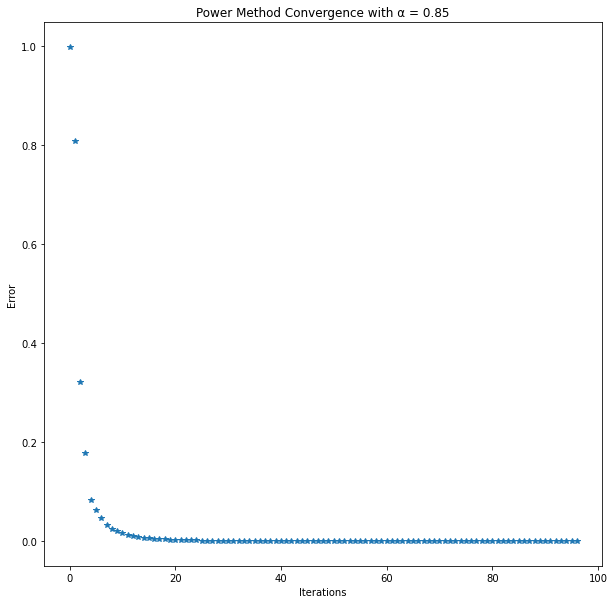

In [24]:
plot_method_convergence(power_error_per_iter.keys(), power_error_per_iter.values(), "Iterations", "Error", "Power Method Convergence with α = 0.85")

* Rate of Convergence

We expect the algorithm to converge in accordance with the rate : $ \frac{|\lambda_2|}{|\lambda_1|}$, where the $\lambda_1, \lambda_2 $ are the 1st and the 2nd eigenvalues

In [25]:
power_eigenvalues = np.sort(-power_x.toarray())[0,:]

In [26]:
lambda1_power = power_eigenvalues[0]
lambda2_power = power_eigenvalues[1]
power_rate = np.abs(lambda2_power)/ np.abs(lambda1_power)
power_rate

0.814433713614242

We can observe that the power method's convergence rate is equal to 0.814433713614242

* Also we can calculate the expected iterations by the theory, in order to compare them with our observed number. 

In [27]:
power_estimate = np.log10(1e-08) / np.log10(0.85)
power_estimate

113.34483189667185

A rough estimate of the number of iterations needed to converge to a tolerance level τ. For τ = $10^{−8}$ and α = .85, one can expect roughly 113 iterations until convergence, and we can observe that there is a slight deviation between the expected and the real number of iterations needed. Actually this difference is 113-96=17 itterations

##### By solving the corresponding system

In [28]:
per_iteration_convergence = []
error_per_iter = {}
def solve_GaussSeidel_method(P, alpha, tol, max_it):
    #this is counter to count the algorithm iterations
    iteration = 0
    # we define error as 1
    error = 1
    aP = alpha * P
    I_aP = (scipy.sparse.eye(P.shape[0], format = 'csc') - aP).T 
    
    # L
    I_aP_L = scipy.sparse.tril(I_aP, k = 0, format = 'csc') 
    # U
    I_aP_U = - scipy.sparse.triu(I_aP, k = 1, format = 'csc')
    
    v = scipy.sparse.csc_matrix(np.ones((P.shape[0], 1)) / P.shape[0])     
    b = scipy.sparse.csc_matrix(((1 - alpha) * v)) 
    # We now create the first x
    x_0 = scipy.sparse.csc_matrix(np.ones((P.shape[0], 1)) / P.shape[0])
    
    while (error > tol) and (iteration < max_it):
    
        x = x_0.copy()
            
        x = scipy.sparse.linalg.spsolve(I_aP_L, I_aP_U.dot(x.reshape(P.shape[0], 1)) + b.reshape(P.shape[0], 1))
            
        error = np.linalg.norm(x.reshape(P.shape[0], 1) - x_0.reshape(P.shape[0], 1), ord = 1)
        
        # we insert the value of x to x_0 as the previous state for the next iteration
        x_0 = x
        # In order to keep track of convergence we store, per iteration the vector x, sorted in descending order.
        per_iteration_convergence.append((np.argsort(-np.asarray(x)) + 1).reshape(P.shape[0]))
        
        print("Iteration %6d, error : %5.10f" %(iteration, error))
        error_per_iter[iteration] = error
        
        iteration += 1
    x = x / np.linalg.norm(x, ord = 1)

    # Compute the vector of page ranks (we add one because we want to turn the zero-based indexing to page indexing.
    rank = (np.argsort(-np.asarray(x)) + 1).reshape(P.shape[0])
    
    return rank, iteration, x, error_per_iter, per_iteration_convergence

* Definition of α and tolerance

In [29]:
alpha=0.85
tolerance = 1e-08

In [30]:
system_rank, system_iteration, system_x, system_error_per_iter, system_conv_iter = solve_GaussSeidel_method(P=sparse_row_matrix, alpha=alpha, tol=tolerance, max_it = 1000000)

Iteration      0, error : 0.9273992401
Iteration      1, error : 0.2820664365
Iteration      2, error : 0.0882637328
Iteration      3, error : 0.0356129128
Iteration      4, error : 0.0174217830
Iteration      5, error : 0.0095841295
Iteration      6, error : 0.0055742610
Iteration      7, error : 0.0033780255
Iteration      8, error : 0.0021118484
Iteration      9, error : 0.0013556270
Iteration     10, error : 0.0008894561
Iteration     11, error : 0.0005925297
Iteration     12, error : 0.0004009443
Iteration     13, error : 0.0002739690
Iteration     14, error : 0.0001890711
Iteration     15, error : 0.0001315950
Iteration     16, error : 0.0000922076
Iteration     17, error : 0.0000649112
Iteration     18, error : 0.0000459725
Iteration     19, error : 0.0000326516
Iteration     20, error : 0.0000232911
Iteration     21, error : 0.0000166521
Iteration     22, error : 0.0000119424
Iteration     23, error : 0.0000085775
Iteration     24, error : 0.0000061783
Iteration     25, error :

In [31]:
print("The algorithm based on the Gauss-Seidel method with α = %5.2f and tolerance = %5.10f has converged after %3d iterations with error = %5.10f" 
      %(alpha, tolerance ,system_iteration-1, system_error_per_iter[system_iteration-1]))

The algorithm based on the Gauss-Seidel method with α =  0.85 and tolerance = 0.0000000100 has converged after  45 iterations with error = 0.0000000080


* So now we can observe the first 25 rankings calculated by our algorithm

In [32]:
probs = - np.sort(-system_x)[:25]

In [33]:
pd.DataFrame(list(zip(system_rank[:25], probs)), columns=['Nodes', 'Probabilities'])

,Nodes,Probabilities
0,89073,0.009703
1,226411,0.007902
2,241454,0.006903
3,134832,0.003608
4,136821,0.003207
5,68889,0.003177
6,67756,0.002958
7,69358,0.002824
8,272442,0.002805
9,251796,0.002805


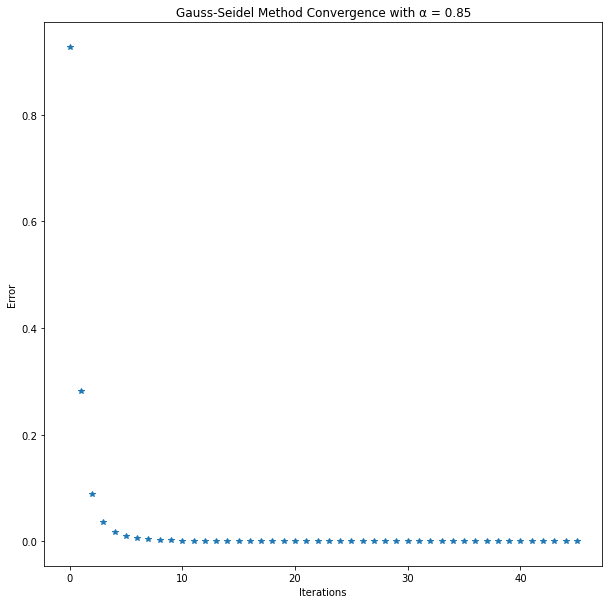

In [34]:
plot_method_convergence(system_error_per_iter.keys(), system_error_per_iter.values(), "Iterations", "Error", "Gauss-Seidel Method Convergence with α = 0.85")

* So now we can compare the two methods.

First of all we can admit that the Gauss-Seidel Method needed 45 iterations with α = 0.85 and tolerance $10^{-8}$ in contrast with the Power Method, where 96 iterations needed respectively. Which is something sound since from the theory we know that the Gauss-Seidel method is expected to converge at lower iterations, for the same tolerance value, when compared to the Power method.

We can now check if the results are the same for both methods.

In [35]:
check_both_0_85 =pd.DataFrame(list(zip(power_rank[:50], system_rank[:50])), columns=['Power_Nodes', 'Gauss-Seidel'])
check_both_0_85

,Power_Nodes,Gauss-Seidel
0,89073,89073
1,226411,226411
2,241454,241454
3,134832,134832
4,136821,136821
5,68889,68889
6,67756,67756
7,69358,69358
8,272442,272442
9,251796,251796


In [36]:
equal_ranks = np.count_nonzero(power_rank == system_rank)
equal_ranks

158769

In [37]:
equal_ranks / np.unique(np.concatenate([df['Node'],df['Outlink']])).shape[0]

0.5632043646218735

* So we can see that only the 56% of all rankings are the same between the two methods.

#### Part 1b)

<font color='green'> Do the previous task with α = 0.99. Your remarks on the convergence speed. Did
the ranking of the first 50 nodes changed?
</font>

##### The Power Method

*  Definition of α and tolerance

In [38]:
alpha=0.99
tolerance = 1e-08

In [39]:
power_rank, power_iteration, power_x, power_error_per_iter,_ = solve_power_method(P=sparse_row_matrix, alpha=alpha, tol=tolerance, max_it = 10000)

Iteration      0, error : 0.9990626513
Iteration      1, error : 0.9832036363
Iteration      2, error : 0.4925624892
Iteration      3, error : 0.3460700590
Iteration      4, error : 0.1935137711
Iteration      5, error : 0.1779920318
Iteration      6, error : 0.1662127013
Iteration      7, error : 0.1461470358
Iteration      8, error : 0.1329175238
Iteration      9, error : 0.1338840991
Iteration     10, error : 0.1273463126
Iteration     11, error : 0.1235796476
Iteration     12, error : 0.1190579462
Iteration     13, error : 0.1175159551
Iteration     14, error : 0.1139083241
Iteration     15, error : 0.1127642710
Iteration     16, error : 0.1100471636
Iteration     17, error : 0.1092133521
Iteration     18, error : 0.1068621817
Iteration     19, error : 0.1063134871
Iteration     20, error : 0.1041672752
Iteration     21, error : 0.1036514804
Iteration     22, error : 0.1017420934
Iteration     23, error : 0.1012230484
Iteration     24, error : 0.0993691565
Iteration     25, error :

In [40]:
print("The algorithm based on the power method with α = %5.2f and tolerance = %5.10f has converged after %3d iterations with error = %5.10f" 
      %(alpha, tolerance ,power_iteration-1, power_error_per_iter[power_iteration-1]))

The algorithm based on the power method with α =  0.99 and tolerance = 0.0000000100 has converged after 1611 iterations with error = 0.0000000100


In other words the number of iterations has been exploded to 1611 in contrast with the only 96 with α = 0.85

* So now we can observe the first 25 rankings calculated by our algorithm

In [41]:
probs = - np.sort(-power_x.toarray())[0,:25]

In [42]:
pd.DataFrame(list(zip(power_rank[:25], probs)), columns=['Nodes', 'Probabilities'])

,Nodes,Probabilities
0,136821,0.002782
1,68889,0.002752
2,95163,0.002388
3,272442,0.002388
4,251796,0.002388
5,119479,0.002101
6,117152,0.001610
7,235496,0.001471
8,27904,0.001245
9,272762,0.001245


In [43]:
def plot_method_convergence(x, y, x_label, y_label, title):
    plt.figure(figsize=(10,10))
    plt.plot(x, y, '*')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show

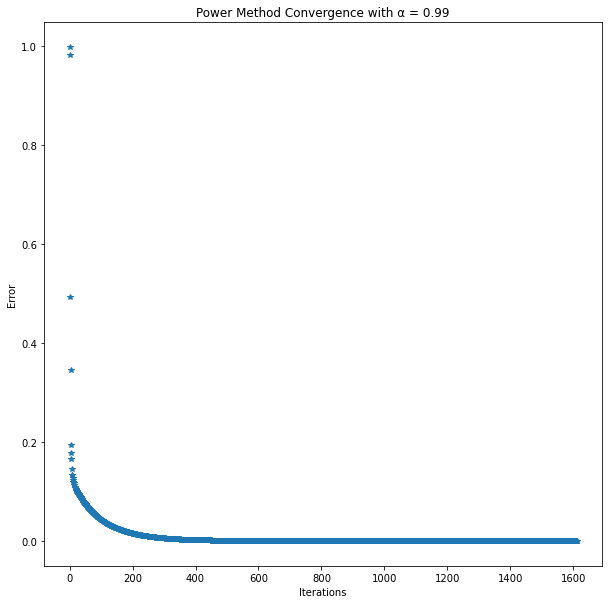

In [44]:
plot_method_convergence(power_error_per_iter.keys(), power_error_per_iter.values(), "Iterations", "Error", "Power Method Convergence with α = 0.99")

##### By solving the corresponding system

In [45]:
system_rank, system_iteration, system_x, system_error_per_iter, _ = solve_GaussSeidel_method(P=sparse_row_matrix, alpha=alpha, tol=tolerance, max_it = 1000000)

Iteration      0, error : 1.0769559629
Iteration      1, error : 0.4060179426
Iteration      2, error : 0.1644473871
Iteration      3, error : 0.0857039665
Iteration      4, error : 0.0532874004
Iteration      5, error : 0.0366727975
Iteration      6, error : 0.0266240049
Iteration      7, error : 0.0200713756
Iteration      8, error : 0.0155718380
Iteration      9, error : 0.0123829057
Iteration     10, error : 0.0100763630
Iteration     11, error : 0.0083072688
Iteration     12, error : 0.0069815972
Iteration     13, error : 0.0059235566
Iteration     14, error : 0.0050872502
Iteration     15, error : 0.0044222005
Iteration     16, error : 0.0038838707
Iteration     17, error : 0.0034329152
Iteration     18, error : 0.0030698697
Iteration     19, error : 0.0027601646
Iteration     20, error : 0.0025018176
Iteration     21, error : 0.0022782630
Iteration     22, error : 0.0020863893
Iteration     23, error : 0.0019207241
Iteration     24, error : 0.0017782135
Iteration     25, error :

In [46]:
print("The algorithm based on the Gauss-Seidel method with α = %5.2f and tolerance = %5.10f has converged after %3d iterations with error = %5.10f" 
      %(alpha, tolerance ,system_iteration-1, system_error_per_iter[system_iteration-1]))

The algorithm based on the Gauss-Seidel method with α =  0.99 and tolerance = 0.0000000100 has converged after 579 iterations with error = 0.0000000100


* Approximately the half in comparison with the Power counterpart.

* So now we can observe the first 25 rankings calculated by our algorithm

In [47]:
probs = - np.sort(-system_x)[:25]

In [48]:
pd.DataFrame(list(zip(system_rank[:25], probs)), columns=['Nodes', 'Probabilities'])

,Nodes,Probabilities
0,136821,0.006015
1,68889,0.005950
2,272442,0.005163
3,251796,0.005163
4,95163,0.005163
5,119479,0.004542
6,117152,0.003481
7,235496,0.003179
8,27904,0.002691
9,272762,0.002691


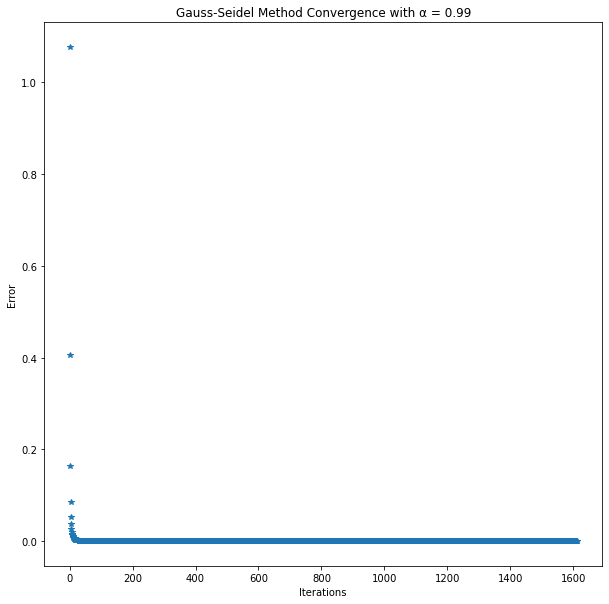

In [49]:
plot_method_convergence(system_error_per_iter.keys(), system_error_per_iter.values(), "Iterations", "Error", "Gauss-Seidel Method Convergence with α = 0.99")

* So now we can compare the two methods.

First of all we can admit that the Gauss-Seidel Method needed 1611 iterations with α = 0.99 and tolerance $10^{-8}$ in contrast with the Power Method, where 579 iterations needed respectively. Which is something sound since from the theory we know that the Gauss-Seidel method is expected to converge at lower iterations, for the same tolerance value, when compared to the Power method. Also we can observe that the number of iterations needed has been increased, this is sound because the fact that the value of α has been increased from 0.85 to 0.99

We can now check if the results are the same for both methods.

In [50]:
check_both_0_99 = pd.DataFrame(list(zip(power_rank[:50], system_rank[:50])), columns=['Power_Nodes', 'Gauss-Seidel'])
check_both_0_99

,Power_Nodes,Gauss-Seidel
0,136821,136821
1,68889,68889
2,95163,272442
3,272442,251796
4,251796,95163
5,119479,119479
6,117152,117152
7,235496,235496
8,27904,27904
9,272762,272762


In [51]:
equal_ranks = np.count_nonzero(power_rank == system_rank)
equal_ranks

147351

In [52]:
equal_ranks / np.unique(np.concatenate([df['Node'],df['Outlink']])).shape[0]

0.5227010709357474

* So we can see that only the 52% of all rankings are the same between the two methods when α=0.99.

In [53]:
check_both_0_85.rename(columns = {'Power_Nodes':'Power_Nodes(α=0.85)', 'Gauss-Seidel':'Gauss-Seidel(α=0.85)'}, inplace = True)
check_both_0_99.rename(columns = {'Power_Nodes':'Power_Nodes(α=0.99)', 'Gauss-Seidel':'Gauss-Seidel(α=0.99)'}, inplace = True)

In [54]:
check_all = pd.concat([check_both_0_85, check_both_0_99], axis=1)
check_all

,Power_Nodes(α=0.85),Gauss-Seidel(α=0.85),Power_Nodes(α=0.99),Gauss-Seidel(α=0.99)
0,89073,89073,136821,136821
1,226411,226411,68889,68889
2,241454,241454,95163,272442
3,134832,134832,272442,251796
4,136821,136821,251796,95163
5,68889,68889,119479,119479
6,67756,67756,117152,117152
7,69358,69358,235496,235496
8,272442,272442,27904,27904
9,251796,251796,272762,272762


* As we can observe by looking the first 50 rankings the majority of ranks are equal in terms that they are in the both sets, but their positions have changed. For example the node 89073, which it was first in both two implementations where α was 0.85, when the α = 0.99 are found in the 11nth position. So we can say that the ranking has changed. But it is known that lower values of α would cause the algorithm to run faster but in expense of stability issues. One can assume that these stability issues would be inaccuracies in the final π vector.

#### Part 1c)

<font color='green'> When we use the power method do all the components of π converge at the same speed to their limits? If not which of the converge faster: those that correspond to important nodes or to non important ? Do you observe the same behavior when you find π through the solution of the linear system?.</font > 

###### Power Method

* For this we take the converged pages for the 1st iteration and compare them with the final ranking

In [55]:
conv_iter_power[0]

array([226411, 241454,  89073, ...,  92954,  92820,      1], dtype=int64)

* Top 100 

In [56]:
counter0 = 0
counter1 = 0
counter2 = 0
for index, page in enumerate(power_rank[:100]):
    if conv_iter_power[0][index] == page:
        counter0 += 1
    elif conv_iter_power[1][index] == page:
        counter1 += 1
    elif conv_iter_power[2][index] == page:
        counter2 += 1

In [57]:
print("Total nodes converged in their limit(top ranked 100) with the 1st iteration :", counter0, ",with the 2nd iteration : ", counter1 , "and with the 3rd : ", counter2)  

Total nodes converged in their limit(top ranked 100) with the 1st iteration : 0 ,with the 2nd iteration :  0 and with the 3rd :  0


* Last 100

In [58]:
counter0_ni = 0
counter1_ni = 0
counter2_ni = 0
for index, page in enumerate(power_rank[len(power_rank)-100:]):
    if conv_iter_power[0][index] == page:
        counter0_ni += 1
    elif conv_iter_power[1][index] == page:
        counter1_ni += 1
    elif conv_iter_power[2][index] == page:
        counter2_ni += 1

In [59]:
print("Total nodes converged in their limit(last 100) with the 1st iteration :", counter0_ni, "with the 2nd iteration : ", counter1_ni , "and with the 3rd : ", counter2_ni)  

Total nodes converged in their limit(last 100) with the 1st iteration : 0 with the 2nd iteration :  0 and with the 3rd :  0


###### By solving the system

* For this we take the converged pages for the 1st iteration and compare them with the final ranking

In [60]:
system_conv_iter[0]

array([226411, 241454,  89073, ..., 111427, 111470,      1], dtype=int64)

* Top 100 

In [61]:
counter0 = 0
counter1 = 0
counter2 = 0
for index, page in enumerate(system_rank[:100]):
    if system_conv_iter[0][index] == page:
        counter0 += 1
    elif system_conv_iter[1][index] == page:
        counter1 += 1
    elif system_conv_iter[2][index] == page:
        counter2 += 1

In [62]:
print("Total nodes converged in their limit(top ranked 100) with the 1st iteration :", counter0, ",with the 2nd iteration : ", counter1 , "and with the 3rd : ", counter2)  

Total nodes converged in their limit(top ranked 100) with the 1st iteration : 0 ,with the 2nd iteration :  0 and with the 3rd :  0


* Last 100

In [63]:
counter0_ni = 0
counter1_ni = 0
counter2_ni = 0
for index, page in enumerate(system_rank[len(system_rank)-100:]):
    if system_conv_iter[0][index] == page:
        counter0_ni += 1
    elif system_conv_iter[1][index] == page:
        counter1_ni += 1
    elif system_conv_iter[2][index] == page:
        counter2_ni += 1

In [64]:
print("Total nodes converged in their limit(last 100) with the 1st iteration :", counter0_ni, "with the 2nd iteration : ", counter1_ni , "and with the 3rd : ", counter2_ni)  

Total nodes converged in their limit(last 100) with the 1st iteration : 0 with the 2nd iteration :  0 and with the 3rd :  0


* So we can say that the more important nodes converge in both methods earlier in contrast with the least ones. Actually there is also a slight difference in the number of converged nodes between the two methods in the first 3 iterations since only 4 nodes have converged with the power method in comparison with 16 nodes from the Gauss-Seidel method.(4 times)

#### Part 2a)

<font color='green'> a) You now create a new web page X (thus adding a node to the web graph). X
has neither in-links, nor out-links. Let ˜π = (˜π1, π˜2, . . . π˜n) denote the vector of
new PageRanks of the n old web pages, and x denote the new PageRank of
page X: In other words, (˜π1, π˜2, . . . , π˜n, x) is the PageRank vector of the new
web graph. Write ˜π and x in terms of r: Comment on how the PageRanks of
1
the older pages changed due to the addition of the new page (remember n is a
very large number). Hint: Use the stationary equations to calculate PageRank,
not the iterative approach.</font > 

* We can insert our page X into position 281904, as our sparse matrix has 281903 nodes 

In [65]:
X = 281904

In [66]:
graph.add_node(X)
sparse_row_matrix_X = nx.to_scipy_sparse_matrix(graph, np.sort(graph.nodes), format = 'csr', dtype = np.float64)
# When a webpage has no outgoing links, we add a 1 as the corresponding diagonal element of P for making its row-sum one.
# we did -1 in order to find the node (starting from 0)
sparse_row_matrix_X[X - 1, X - 1] = 1.0

C:\Users\giann\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


* Since we now have the new matrix(with X) we can proceed to our computation of Page Rank using the Power Method.

In [67]:
alpha=0.85
tolerance = 1e-08

In [68]:
power_rank_X, power_iteration_X, power_x_X, power_error_per_iter_X,_ = solve_power_method(P=sparse_row_matrix_X, alpha=alpha, tol=tolerance, max_it = 10000)

Iteration      0, error : 0.9987260893
Iteration      1, error : 0.8090718708
Iteration      2, error : 0.3207950437
Iteration      3, error : 0.1772026435
Iteration      4, error : 0.0837620450
Iteration      5, error : 0.0620478826
Iteration      6, error : 0.0467064881
Iteration      7, error : 0.0332607135
Iteration      8, error : 0.0249306186
Iteration      9, error : 0.0204853403
Iteration     10, error : 0.0162034108
Iteration     11, error : 0.0129875866
Iteration     12, error : 0.0105392379
Iteration     13, error : 0.0086725551
Iteration     14, error : 0.0071444328
Iteration     15, error : 0.0059383225
Iteration     16, error : 0.0049553034
Iteration     17, error : 0.0041488138
Iteration     18, error : 0.0034847760
Iteration     19, error : 0.0029341342
Iteration     20, error : 0.0024738478
Iteration     21, error : 0.0020878799
Iteration     22, error : 0.0017662150
Iteration     23, error : 0.0014926639
Iteration     24, error : 0.0012640462
Iteration     25, error :

In [69]:
print("The algorithm based on the power method with α = %5.2f and tolerance = %5.10f has converged after %3d iterations with error = %5.10f" 
      %(alpha, tolerance ,power_iteration_X-1, power_error_per_iter_X[power_iteration_X-1]))

The algorithm based on the power method with α =  0.85 and tolerance = 0.0000000100 has converged after  96 iterations with error = 0.0000000097


In [70]:
probs = - np.sort(-power_x_X.toarray())[0,:]

In [71]:
df_X = pd.DataFrame(list(zip(power_rank_X[:], probs)), columns=['Nodes', 'Probabilities'])
df_X

,Nodes,Probabilities
0,89073,7.420444e-03
1,226411,6.043460e-03
2,241454,5.279183e-03
3,134832,2.759486e-03
4,136821,2.452385e-03
...,...,...
281899,55615,5.330863e-07
281900,220312,5.330863e-07
281901,220337,5.330863e-07
281902,220295,5.330863e-07


In [72]:
df_X[df_X['Nodes'] == X]

,Nodes,Probabilities
42593,281904,0.000004


In [73]:
df_X.head(25)

,Nodes,Probabilities
0,89073,0.007420
1,226411,0.006043
2,241454,0.005279
3,134832,0.002759
4,136821,0.002452
5,68889,0.002429
6,67756,0.002263
7,69358,0.002160
8,272442,0.002145
9,95163,0.002145


* We can observe that our page ranking, which is 42593. As for the ranks for the previous nodes they seem same as previous.

#### Part 2b)

<font color='green'>Unsatisfied with the PageRank of your page X; you create another page Y (with
no in-links) that links to X: What are the PageRanks of all the n + 2 pages
now? Does the PageRank of X improve?</font>

In [74]:
Y = 281905
graph.add_node(Y)
graph.add_edge(Y, X, weight = 1)
sparse_row_matrix_X_Y = nx.to_scipy_sparse_matrix(graph, np.sort(graph.nodes), format = 'csr', dtype = np.float64)

In [75]:
subgraph = graph.subgraph([X, Y])

<AxesSubplot:>

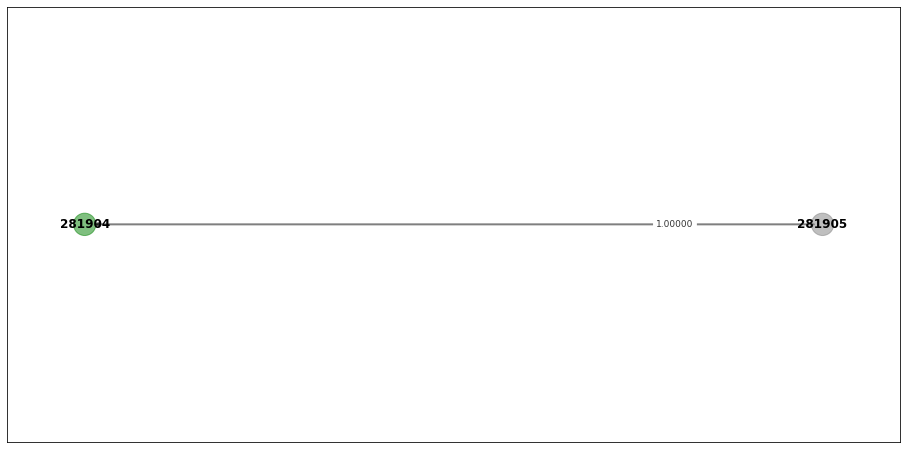

In [76]:
plot_graph(graph = subgraph, highlight_nodes = [X], size = (16, 8))

In [77]:
power_rank_XY, power_iteration_XY, power_x_XY, power_error_per_iter_XY,_ = solve_power_method(P=sparse_row_matrix_X_Y, alpha=alpha, tol=tolerance, max_it = 10000)

Iteration      0, error : 0.9987260848
Iteration      1, error : 0.8090651683
Iteration      2, error : 0.3207904651
Iteration      3, error : 0.1772025242
Iteration      4, error : 0.0837619605
Iteration      5, error : 0.0620479497
Iteration      6, error : 0.0467064059
Iteration      7, error : 0.0332607129
Iteration      8, error : 0.0249305982
Iteration      9, error : 0.0204853015
Iteration     10, error : 0.0162033711
Iteration     11, error : 0.0129875490
Iteration     12, error : 0.0105392017
Iteration     13, error : 0.0086725214
Iteration     14, error : 0.0071444025
Iteration     15, error : 0.0059382956
Iteration     16, error : 0.0049552798
Iteration     17, error : 0.0041487933
Iteration     18, error : 0.0034847583
Iteration     19, error : 0.0029341190
Iteration     20, error : 0.0024738348
Iteration     21, error : 0.0020878687
Iteration     22, error : 0.0017662055
Iteration     23, error : 0.0014926558
Iteration     24, error : 0.0012640393
Iteration     25, error :

In [78]:
print("The algorithm based on the power method with α = %5.2f and tolerance = %5.10f has converged after %3d iterations with error = %5.10f" 
      %(alpha, tolerance ,power_iteration_XY-1, power_error_per_iter_XY[power_iteration_XY-1]))

The algorithm based on the power method with α =  0.85 and tolerance = 0.0000000100 has converged after  96 iterations with error = 0.0000000097


In [79]:
probs = - np.sort(-power_x_XY.toarray())[0,:]

In [80]:
df_XY = pd.DataFrame(list(zip(power_rank_XY[:], probs)), columns=['Nodes', 'Probabilities'])
df_XY

,Nodes,Probabilities
0,89073,7.420459e-03
1,226411,6.043472e-03
2,241454,5.279194e-03
3,134832,2.759492e-03
4,136821,2.452390e-03
...,...,...
281900,175506,5.330874e-07
281901,175517,5.330874e-07
281902,175549,5.330874e-07
281903,175264,5.330874e-07


In [81]:
df_XY[df_XY['Nodes'] == X]

,Nodes,Probabilities
141864,281904,9.862117e-07


In [82]:
df_XY[df_XY['Nodes'] == Y]

,Nodes,Probabilities
281904,281905,5.330874e-07


In [83]:
df_X.head(25)

,Nodes,Probabilities
0,89073,0.007420
1,226411,0.006043
2,241454,0.005279
3,134832,0.002759
4,136821,0.002452
5,68889,0.002429
6,67756,0.002263
7,69358,0.002160
8,272442,0.002145
9,95163,0.002145


* We observe that the ranking of X decreases and the position of Y is 281904. So our initial assumption that the X's ranking will increase if we insert a new page Y was wrong.

#### Part 2c)

<font color='green'> Still unsatisfied, you create a third page Z: How should you set up the links on
your three pages so as to maximize the PageRank of X?</font>

In [84]:
Z = 281906
graph.add_node(Z)
graph.add_edge(Z, Y, weight = 1)
sparse_row_matrix_X_Y_Z = nx.to_scipy_sparse_matrix(graph, np.sort(graph.nodes), format = 'csr', dtype = np.float64)

In [85]:
subgraph = graph.subgraph([X, Y, Z])

<AxesSubplot:>

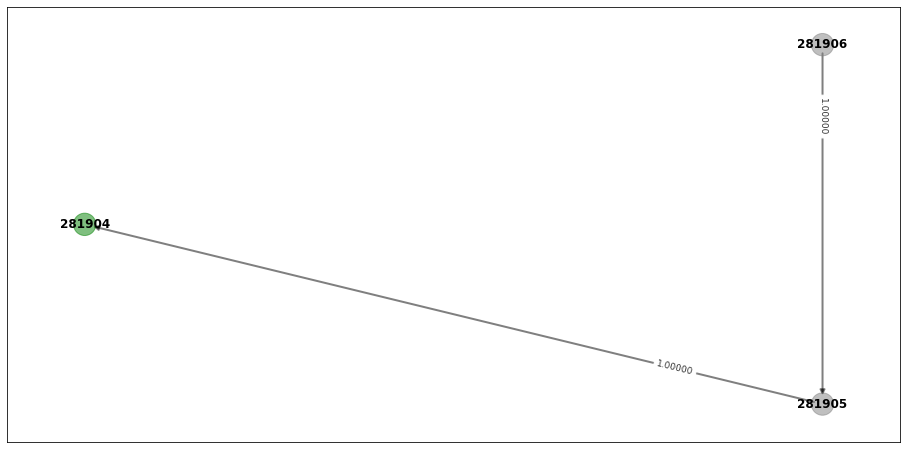

In [86]:
plot_graph(graph = subgraph, highlight_nodes = [X], size = (16, 8))

In [87]:
power_rank_XYZ, power_iteration_XYZ, power_x_XYZ, power_error_per_iter_XYZ,_ = solve_power_method(P=sparse_row_matrix_X_Y_Z, alpha=alpha, tol=tolerance, max_it = 10000)

Iteration      0, error : 0.9987260802
Iteration      1, error : 0.8090651641
Iteration      2, error : 0.3207904763
Iteration      3, error : 0.1771992357
Iteration      4, error : 0.0837626235
Iteration      5, error : 0.0620480267
Iteration      6, error : 0.0467064405
Iteration      7, error : 0.0332606304
Iteration      8, error : 0.0249305636
Iteration      9, error : 0.0204852677
Iteration     10, error : 0.0162033287
Iteration     11, error : 0.0129875064
Iteration     12, error : 0.0105391633
Iteration     13, error : 0.0086724862
Iteration     14, error : 0.0071443707
Iteration     15, error : 0.0059382674
Iteration     16, error : 0.0049552553
Iteration     17, error : 0.0041487719
Iteration     18, error : 0.0034847399
Iteration     19, error : 0.0029341032
Iteration     20, error : 0.0024738212
Iteration     21, error : 0.0020878572
Iteration     22, error : 0.0017661957
Iteration     23, error : 0.0014926474
Iteration     24, error : 0.0012640322
Iteration     25, error :

In [88]:
print("The algorithm based on the power method with α = %5.2f and tolerance = %5.10f has converged after %3d iterations with error = %5.10f" 
      %(alpha, tolerance ,power_iteration_XYZ-1, power_error_per_iter_XYZ[power_iteration_XYZ-1]))

The algorithm based on the power method with α =  0.85 and tolerance = 0.0000000100 has converged after  96 iterations with error = 0.0000000097


In [89]:
probs = - np.sort(-power_x_XYZ.toarray())[0,:]

In [90]:
df_XYZ = pd.DataFrame(list(zip(power_rank_XYZ[:], probs)), columns=['Nodes', 'Probabilities'])
df_XYZ

,Nodes,Probabilities
0,89073,7.420449e-03
1,226411,6.043464e-03
2,241454,5.279187e-03
3,134832,2.759488e-03
4,136821,2.452386e-03
...,...,...
281901,175506,5.330867e-07
281902,175517,5.330867e-07
281903,175549,5.330867e-07
281904,175264,5.330867e-07


In [91]:
df_XYZ[df_XYZ['Nodes'] == X]

,Nodes,Probabilities
107045,281904,0.000001


In [92]:
df_XYZ[df_XYZ['Nodes'] == Y]

,Nodes,Probabilities
141899,281905,9.862103e-07


In [93]:
df_XYZ[df_XYZ['Nodes'] == Z]

,Nodes,Probabilities
281905,281906,5.330867e-07


In [94]:
df_X.head(25)

,Nodes,Probabilities
0,89073,0.007420
1,226411,0.006043
2,241454,0.005279
3,134832,0.002759
4,136821,0.002452
5,68889,0.002429
6,67756,0.002263
7,69358,0.002160
8,272442,0.002145
9,95163,0.002145


* We can observe now that although the ranking of X increased still is lower than its initial insertion, so our insertions do not help the PageRank of X.

#### Part 2d)

<font color='green'> You have one last idea, you add links from your page X to older, popular pages
(e.g.: you add a list of ?Useful links? on your page). Does this improve the
PageRank of X? Does the answer change if you add links from Y or Z to older,
popular pages?</font>

* So we can exploit the first 10 pages.

In [95]:
alpha=0.85
tolerance = 1e-08

In [96]:
pd.DataFrame(list(zip(power_rank[:25], probs)), columns=['Nodes', 'Probabilities'])

,Nodes,Probabilities
0,136821,0.007420
1,68889,0.006043
2,95163,0.005279
3,272442,0.002759
4,251796,0.002452
5,119479,0.002429
6,117152,0.002263
7,235496,0.002160
8,27904,0.002145
9,272762,0.002145


* And now we can define the new edges to our clear graph

In [97]:
X = 281904
graph.add_node(X)
for page in power_rank[:10]:
    #we define as weight the 1/10
    graph.add_edge(X, page, weight = 1/10)
sparse_row_matrix_X = nx.to_scipy_sparse_matrix(graph, np.sort(graph.nodes), format = 'csr', dtype = np.float64)


In [98]:
subgraph = graph.subgraph(np.concatenate([[X], power_rank[:10]]))

<AxesSubplot:>

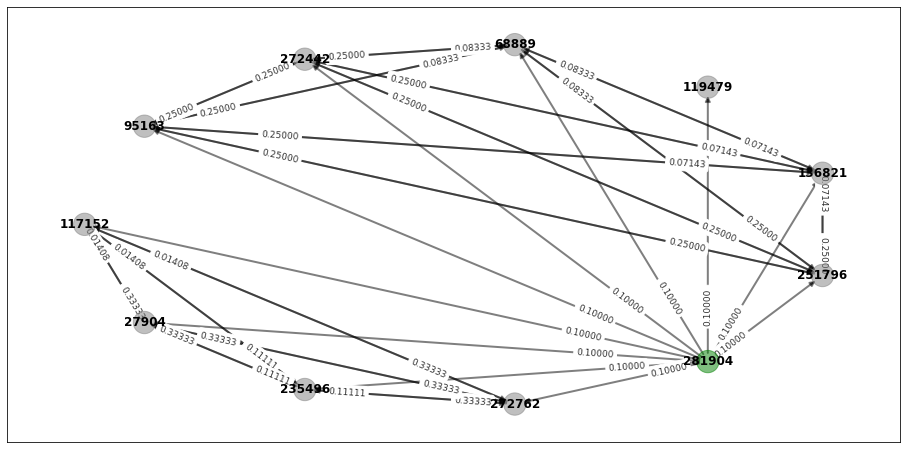

In [99]:
plot_graph(graph = subgraph, highlight_nodes = [X], size = (16, 8))

In [100]:
power_rank_X_new, power_iteration_X_new, power_x_X_new, power_error_per_iter_X_new,_ = solve_power_method(P=sparse_row_matrix_X, alpha=alpha, tol=tolerance, max_it = 10000)

Iteration      0, error : 0.9987260934
Iteration      1, error : 0.8090596973
Iteration      2, error : 0.3207864380
Iteration      3, error : 0.1771978746
Iteration      4, error : 0.0837596300
Iteration      5, error : 0.0620458531
Iteration      6, error : 0.0467048467
Iteration      7, error : 0.0332594880
Iteration      8, error : 0.0249296734
Iteration      9, error : 0.0204845441
Iteration     10, error : 0.0162027717
Iteration     11, error : 0.0129870680
Iteration     12, error : 0.0105388141
Iteration     13, error : 0.0086722041
Iteration     14, error : 0.0071441426
Iteration     15, error : 0.0059380804
Iteration     16, error : 0.0049551011
Iteration     17, error : 0.0041486441
Iteration     18, error : 0.0034846333
Iteration     19, error : 0.0029340139
Iteration     20, error : 0.0024737463
Iteration     21, error : 0.0020877942
Iteration     22, error : 0.0017661425
Iteration     23, error : 0.0014926026
Iteration     24, error : 0.0012639943
Iteration     25, error :

In [101]:
print("The algorithm based on the power method with α = %5.2f and tolerance = %5.10f has converged after %3d iterations with error = %5.10f" 
      %(alpha, tolerance ,power_iteration_X_new-1, power_error_per_iter_X_new[power_iteration_X_new-1]))

The algorithm based on the power method with α =  0.85 and tolerance = 0.0000000100 has converged after  96 iterations with error = 0.0000000097


In [102]:
probs = - np.sort(-power_x_X_new.toarray())[0,:]

In [103]:
df_X_new = pd.DataFrame(list(zip(power_rank_X_new[:], probs)), columns=['Nodes', 'Probabilities'])
df_X_new

,Nodes,Probabilities
0,89073,7.420391e-03
1,226411,6.043417e-03
2,241454,5.279146e-03
3,134832,2.759466e-03
4,136821,2.453016e-03
...,...,...
281901,175506,5.330825e-07
281902,175517,5.330825e-07
281903,175549,5.330825e-07
281904,175264,5.330825e-07


In [104]:
df_X_new[df_X_new['Nodes'] == X]

,Nodes,Probabilities
107045,281904,0.000001


* As we can observe the position of X is now again 107045, so we can say that there is not improvement in our page ranking.

* So, as a last try we can now try to link the Y and Z with the top older pages.

In [105]:
X = 281904
Y = 281905
Z = 281906
graph.add_node(X)
graph.add_node(Y)
graph.add_node(Z)
for page in power_rank[:10]:
    #we define as weight the 1/10
    graph.add_edge(X, page, weight = 1/10)
    graph.add_edge(Y, page, weight = 1/10)
    graph.add_edge(Z, page, weight = 1/10)
sparse_row_matrix_X = nx.to_scipy_sparse_matrix(graph, np.sort(graph.nodes), format = 'csr', dtype = np.float64)


In [106]:
subgraph = graph.subgraph(np.concatenate([[X, Y, Z], power_rank[:10]]))

<AxesSubplot:>

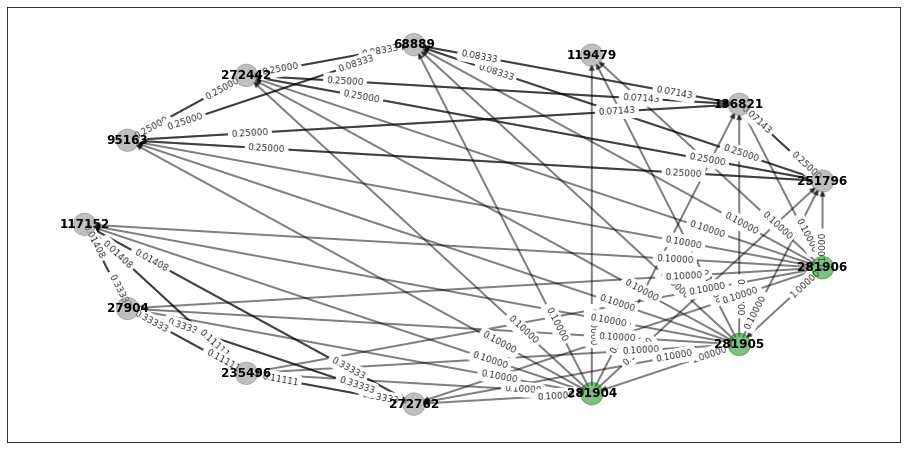

In [107]:
plot_graph(graph = subgraph, highlight_nodes = [X, Y, Z], size = (16, 8))

In [108]:
power_rank_XYZ_new, power_iteration_XYZ_new, power_x_XYZ_new, power_error_per_iter_XYZ_new,_ = solve_power_method(P=sparse_row_matrix_X, alpha=alpha, tol=tolerance, max_it = 10000)

Iteration      0, error : 0.9987261044
Iteration      1, error : 0.8090443179
Iteration      2, error : 0.3207787563
Iteration      3, error : 0.1771922305
Iteration      4, error : 0.0837568060
Iteration      5, error : 0.0620435714
Iteration      6, error : 0.0467030162
Iteration      7, error : 0.0332581243
Iteration      8, error : 0.0249286232
Iteration      9, error : 0.0204836606
Iteration     10, error : 0.0162020627
Iteration     11, error : 0.0129864928
Iteration     12, error : 0.0105383440
Iteration     13, error : 0.0086718148
Iteration     14, error : 0.0071438208
Iteration     15, error : 0.0059378120
Iteration     16, error : 0.0049548767
Iteration     17, error : 0.0041484558
Iteration     18, error : 0.0034844751
Iteration     19, error : 0.0029338806
Iteration     20, error : 0.0024736338
Iteration     21, error : 0.0020876992
Iteration     22, error : 0.0017660622
Iteration     23, error : 0.0014925346
Iteration     24, error : 0.0012639367
Iteration     25, error :

In [109]:
print("The algorithm based on the power method with α = %5.2f and tolerance = %5.10f has converged after %3d iterations with error = %5.10f" 
      %(alpha, tolerance ,power_iteration_XYZ_new-1, power_error_per_iter_XYZ_new[power_iteration_XYZ_new-1]))

The algorithm based on the power method with α =  0.85 and tolerance = 0.0000000100 has converged after  96 iterations with error = 0.0000000097


In [110]:
probs = - np.sort(-power_x_XYZ_new.toarray())[0,:]

In [111]:
df_XYZ_new = pd.DataFrame(list(zip(power_rank_XYZ_new[:], probs)), columns=['Nodes', 'Probabilities'])
df_XYZ_new

,Nodes,Probabilities
0,89073,7.420391e-03
1,226411,6.043417e-03
2,241454,5.279146e-03
3,134832,2.759466e-03
4,136821,2.453734e-03
...,...,...
281901,175506,5.330825e-07
281902,175517,5.330825e-07
281903,175549,5.330825e-07
281904,175264,5.330825e-07


In [112]:
df_XYZ_new[df_XYZ_new['Nodes'] == X]

,Nodes,Probabilities
107045,281904,0.000001


* Disappointingly, the X's PageRank is still same with the previous step and also still far away from that we want

#### Part 2e)

<font color='green'> Describe what steps you might take to raise the PageRank of X further. You do
not need to prove anything here, just summarize your thoughts based on the
previous parts. For extra credit though, you can prove what the structure for
a link farm with m nodes should be to optimize the PageRank of X</font>

* Based on the previous questions it is obvious that increasing the PageRank of a webpage is a tough task. It is also known that the PageRank of a webpage can be increased if more and more pages point to this webpage(inlinks). Of course, if those webpages have high PageRank then their contribution will be even more significant. Nevertheless, in general, the more pages pointing to a webpage, the higher the PageRank of that page. In other words, we may be able to increase the pageRank of X if we could have links from the top pages pointing our page X.

* https://rocketdigital.ca/improve-pagerank-backlinks/